# League Of Legends Solo-Q Predictions

![League of Legends SOLO-Q Ranked Games](https://storage.googleapis.com/kaggle-datasets-images/616334/1101538/2fb3bf6ad60c3f050712e620a3d8bd35/dataset-cover.jpeg?t=2020-04-22-18-58-24)

##### [Lien vers le Kaggle](https://www.kaggle.com/datasets/bobbyscience/league-of-legends-soloq-ranked-games)

## Contexte

League of Legends est un MOBA (multiplayer online battle arena) où 2 équipes (bleue et rouge) s'affrontent. Il y a 3 couloirs, une jungle et 5 rôles. Le but est d'éliminer le Nexus ennemi pour gagner la partie.

## Contenu

Cet ensemble de données contient les statistiques d'environ **25 000 parties classées** (SOLO QUEUE) d'un ELO Platinium.

Chaque partie est unique. Le **gameId** peut vous aider à obtenir plus d'attributs de l'API de Riot.

Chaque jeu présente des caractéristiques sur différentes périodes de temps, de 10 minutes à la fin du jeu. Par exemple, game1 10min, game1 12min, game1 14min etc.

**Au total, il y a +240000 frames de jeu.** 🔥

Il y a 55 caractéristiques **collectées pour l'équipe BLEUE** 🙏 . Cela inclut les kills, deaths, gold, experience, level... A vous de faire du feature engineering pour obtenir plus d'insights.

La colonne **hasWon** est la valeur cible si vous faites de la classification pour prédire l'issue du jeu.
Sinon, vous pouvez utiliser l'attribut **gameDuration** si vous voulez prédire la durée du match.

Les attributs commençant par is* sont des valeurs catégorielles booléennes (0 ou 1).

## Définition du problème

**Objectif principal** : Prédire la victoire de l'équipe bleue (`hasWon`) en utilisant les différentes métriques du jeu disponibles.

**Type de problème** : Classification binaire supervisée

- *Variable cible* : `hasWon` (1 = victoire équipe bleue, 0 = défaite)
- *Métriques d'évaluation* : Accuracy, Precision, Recall, F1-score, ROC-AUC

## Plan

### [1. Chargement et prétraitement des données](#chargement-pretraitement)

### [2. Étude des corrélations](#analyse)
#### [2.1 Quels aspects ont le plus d'impact sur la victoire en fonction du temps restant ?](#remaining-frames)
##### [2.1.1 Les lanes](#lanes)
##### [2.1.2 Les objectifs neutres](#objectifs)

### [3. Machine Learning](#machine-learning)
#### [3.1 Régression logistique](#logistic-regression)
#### [3.2 kNN](#knn)
#### [3.3 Random Forest](#random-forest)
#### [3.4 Outils d'aide à la décision pour jungler](#jungler)

### [4. Conclusion](#conclusion)

In [1]:
# Manipulation de données
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: f'{int(x)}' if x == int(x) else f'{x:.2f}')
import numpy as np
from sklearn.tree import plot_tree # visualisation des arbres de décision

# Visualisation
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10, 4.8)
import seaborn as sns

# Machine Learning 
from sklearn.preprocessing import StandardScaler # normalisation des données
from sklearn.model_selection import GridSearchCV, KFold, train_test_split # validation croisée, séparation des données, sélection des hyperparamètres
from sklearn.metrics import confusion_matrix, classification_report # évaluation des modèles

from sklearn.linear_model import LogisticRegression # régression logistique
from sklearn.neighbors import KNeighborsClassifier # k plus proches voisins
from sklearn.ensemble import RandomForestClassifier # random forest

# Ignorer les warnings
import warnings
warnings.filterwarnings('ignore')

<h1 id='chargement-pretraitement'>Chargement et prétraitement des données</h1>

In [ ]:
# Chargement des données
df = pd.read_csv('dataset.csv')

# Exploration des données
display(df.head(10))
print(df.info())

# Valeurs manquantes
assert df.isna().sum().sum() == 0, 'Le jeu de données contient des valeurs manquantes'
print(f"{'-'*6}> Aucune valeur manquante dans le jeu de données")

,gameId,gameDuration,hasWon,frame,goldDiff,expDiff,champLevelDiff,isFirstTower,isFirstBlood,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
0,4546233126,1443000,1,10,-448,-147,-0.20,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,7,5,21,3,5
1,4546233126,1443000,1,12,-1306,-925,-0.60,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,11,6,28,4,6
2,4546233126,1443000,1,14,2115,2578,0.40,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,10,11,12,35,4,6
3,4546233126,1443000,1,16,1195,2134,0.40,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,10,12,12,45,6,10
4,4546233126,1443000,1,18,2931,4382,0.60,1,1,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,13,13,16,49,7,12
5,4546233126,1443000,1,20,6127,7606,0.80,1,1,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,1,0,20,14,28,63,9,13
6,4546233126,1443000,1,22,7428,7842,1.40,1,1,1,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,23,15,33,75,10,13
7,4546233126,1443000,1,24,9426,11980,1.80,1,1,2,0,0,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,26,15,36,85,11,14
8,4438212663,1241000,1,10,898,934,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,6,7,15,4,1
9,4438212663,1241000,1,12,1263,1566,0.40,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,7,7,20,5,4


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242572 entries, 0 to 242571
Data columns (total 59 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   gameId                   242572 non-null  int64  
 1   gameDuration             242572 non-null  int64  
 2   hasWon                   242572 non-null  int64  
 3   frame                    242572 non-null  int64  
 4   goldDiff                 242572 non-null  int64  
 5   expDiff                  242572 non-null  int64  
 6   champLevelDiff           242572 non-null  float64
 7   isFirstTower             242572 non-null  int64  
 8   isFirstBlood             242572 non-null  int64  
 9   killedFireDrake          242572 non-null  int64  
 10  killedWaterDrake         242572 non-null  int64  
 11  killedAirDrake           242572 non-null  int64  
 12  killedEarthDrake         242572 non-null  int64  
 13  killedElderDrake         242572 non-null  int64  
 14  lost

On remarque la colonne `gameDuration` qui correspond à la durée de la partie. Étant donné que l'on souhaite par la suite effectuer des prédictions, on ne peut pas se permettre de garder cette colonne. En effet, la durée de la partie est une information qui n'est pas supposée être connue à l'avance. On ne peut donc pas l'utiliser pour prédire le résultat de la partie sinon on tomberait dans un cas de fuite de données (data leakage).

In [3]:
df.drop('gameDuration', axis=1, inplace=True)

On remarque également des colonnes comme notre target (`hasWon`) semblent ne contenir que des 0 et des 1.

On peut donc les convertir en booléen afin qu'elles soient traitées comme telles et non comme des entiers.

In [4]:
# Convertion des colonnes booléennes
for col in ['hasWon', 'isFirstTower', 'isFirstBlood']:
    df[col] = df[col].astype('bool')

In [5]:
# Vérfication du nombre de features de chaque type de données après conversions (bool et timedelta)
print(df.dtypes.value_counts())

int64      54
bool        3
float64     1
Name: count, dtype: int64


<h1 id='aed'>Analyse exploratoire des données (AED)</h1>

On cherche ici à comprendre le jeu de données et à déterminer la meilleure façon de manipuler les sources de données pour obtenir les réponses recherchées.

On commence par définir ce que contient notre jeu de données (ex : nombre de parties unique)

In [6]:
print(f'Le jeu de données contient {df.shape[0]} frames et {df.shape[1]} features par frame.')
print(f'Ces frames représentent un total de {df.gameId.nunique()} parties uniques.')
print(f'Les frames vont de {df.frame.min()} à {df.frame.max()} avec une moyenne de {df.frame.mean()}.')

Le jeu de données contient 242572 frames et 58 features par frame.
Ces frames représentent un total de 24912 parties uniques.
Les frames vont de 10 à 56 avec une moyenne de 19.811264284418648.


Il était noté sur Kaggle que les frames allaient de 2 en 2. On vérifie cela.

In [7]:
frames = sorted(df.frame.unique())
assert all(frames[i+1] - frames[i] == 2 for i in range(len(frames)-1)), 'Les frames ne vont pas de 2 en 2 !'
print(f'Les frames vont de 2 en 2.')

print(f'Chaque ligne représente donc l\'état d\'une partie toutes les 2 minutes (frame) de {df.frame.min()} min à {df.frame.max()} min pour {df.gameId.nunique()} parties.')

Les frames vont de 2 en 2.
Chaque ligne représente donc l'état d'une partie toutes les 2 minutes (frame) de 10 min à 56 min pour 24912 parties.


On peut également regarder quelques statistiques descriptives basiques pour comprendre les données

In [8]:
df.describe()

,gameId,frame,goldDiff,expDiff,champLevelDiff,killedFireDrake,killedWaterDrake,killedAirDrake,killedEarthDrake,killedElderDrake,lostFireDrake,lostWaterDrake,lostAirDrake,lostEarthDrake,lostElderDrake,killedBaronNashor,lostBaronNashor,killedRiftHerald,lostRiftHerald,destroyedTopInhibitor,destroyedMidInhibitor,destroyedBotInhibitor,lostTopInhibitor,lostMidInhibitor,lostBotInhibitor,destroyedTopNexusTurret,destroyedMidNexusTurret,destroyedBotNexusTurret,lostTopNexusTurret,lostMidNexusTurret,lostBotNexusTurret,destroyedTopBaseTurret,destroyedMidBaseTurret,destroyedBotBaseTurret,lostTopBaseTurret,lostMidBaseTurret,lostBotBaseTurret,destroyedTopInnerTurret,destroyedMidInnerTurret,destroyedBotInnerTurret,lostTopInnerTurret,lostMidInnerTurret,lostBotInnerTurret,destroyedTopOuterTurret,destroyedMidOuterTurret,destroyedBotOuterTurret,lostTopOuterTurret,lostMidOuterTurret,lostBotOuterTurret,kills,deaths,assists,wardsPlaced,wardsDestroyed,wardsLost
count,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572,242572
mean,4501479546.20,19.81,-11.41,-215.02,-0.03,0.30,0.30,0.30,0.30,0.01,0.31,0.31,0.32,0.32,0.01,0.14,0.16,0.56,0.62,0.02,0.03,0.09,0.02,0.03,0.08,0.03,0.04,0.10,0.03,0.04,0.09,0,0,0.05,0,0,0.05,0.12,0.12,0.19,0.11,0.12,0.18,0.38,0.38,0.37,0.38,0.37,0.36,16.39,16.34,21.17,56.83,10.49,10.26
std,53316927.63,7.20,5438.05,5261.88,0.77,0.51,0.52,0.52,0.52,0.08,0.52,0.52,0.52,0.53,0.08,0.39,0.41,0.67,0.69,0.15,0.18,0.31,0.15,0.18,0.30,0.18,0.19,0.30,0.17,0.19,0.29,0,0,0.28,0,0,0.28,0.33,0.32,0.39,0.31,0.32,0.38,0.49,0.49,0.48,0.48,0.48,0.48,9.66,9.70,16.06,58.73,8.71,8.74
min,4357970300,10,-21578,-32484,-4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0
25%,4463051383,14,-3420.25,-3148,-0.60,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,9,9,25,4,4
50%,4529395251,18,24,-123,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,15,15,17,40,8,8
75%,4543717936.75,24,3409,2772,0.40,1,1,1,1,0,1,1,1,1,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,22,22,30,63,15,14
max,4547671497,56,23432,43304,3.80,4,4,4,4,3,4,4,4,4,3,4,4,2,2,3,3,4,3,3,4,1,1,1,1,1,1,0,0,2,0,0,2,1,1,1,1,1,1,1,1,1,1,1,1,69,72,137,1014,115,107


Étant donné que l'on va vouloir effectuer des prédictions, il est intéressant de regarder la distribution de la variable cible (`hasWon`)

<Axes: title={'center': 'Distribution de la variable cible (hasWon)'}>

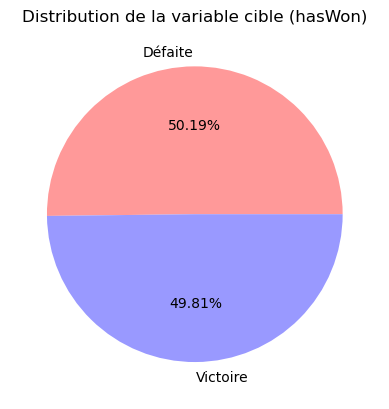

In [9]:
df['hasWon'].value_counts(normalize=True).plot.pie(
    title='Distribution de la variable cible (hasWon)',
    labels=['Défaite', 'Victoire'],
    colors=['#FF9999', '#9999FF'],
    autopct='%.2f%%',
    ylabel=''
)

<h1 id='analyse'>Étude des corrélations</h1>
<h2 id='remaining-frames'>Quels aspects ont le plus d'impact sur la victoire en fonction du temps restant ?</h2>

Dans cette partie, nous allons regarder l'évolution de l'impact de chaque aspect du jeu en fonction du temps restant dans la partie.

À la place de réaliser l'étude par frame, on va plutôt regarder le nombre de frame restante car cela sera plus représentatif de l'aspect qui à le plus d'impact pour finir une partie : si on étudie l'impact d'une feature à la frame 20 de 2 parties dont la première s'est terminée à 22 minutes tandis que l'autre s'est terminée à 56 minutes (maximum dans les données), on trouvera des valeurs radicalement différente et cela est normal.

In [10]:
# on crée une colonne 'remaining_frames' qui indique le nombre de frames restantes dans la partie
df['remaining_frames'] = (df.groupby('gameId')['frame'].transform(lambda x: (x.max() - x) / 2)).astype(int)
df[['gameId', 'frame', 'remaining_frames']].head(14)

,gameId,frame,remaining_frames
0,4546233126,10,7
1,4546233126,12,6
2,4546233126,14,5
3,4546233126,16,4
4,4546233126,18,3
5,4546233126,20,2
6,4546233126,22,1
7,4546233126,24,0
8,4438212663,10,5
9,4438212663,12,4


Afin d'étudier l'impact de chaque aspect du jeu, on va regarder la corrélation entre chaque feature et la victoire (`hasWon`) pour chaque valeur de frames restantes (`remaining_frames`) dans le jeu de données.

In [11]:
correlation_matrix = pd.DataFrame(index=df.drop(['hasWon', 'gameId', 'frame', 'remaining_frames'], axis=1).columns)

for frames_left in sorted(df['remaining_frames'].unique(), reverse=True):
    temp_df = df[df['remaining_frames'] == frames_left] # filtrer les frames restantes
    correlations = temp_df.drop(['hasWon', 'remaining_frames'], axis=1).corrwith(temp_df['hasWon']) # calculer la corrélation
    correlation_matrix[frames_left] = correlations # ajouter la corrélation au DataFrame de résultats

correlation_matrix['mean'] = correlation_matrix.mean(axis=1) # moyenne des corrélations au cours du temps
correlation_matrix = correlation_matrix.reindex(
    correlation_matrix['mean'].abs().sort_values(ascending=False).index
) # trier les corrélations par valeur absolue (on veut les plus fortes corrélations, positives ou négatives)

correlation_matrix

,23,22,21,20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,mean
goldDiff,0.21,-0.15,0.16,-0.04,-0.04,0.02,-0.01,-0.03,-0.02,0.01,0.03,0.08,0.12,0.17,0.23,0.32,0.40,0.48,0.56,0.64,0.71,0.78,0.84,0.90,0.26
champLevelDiff,-0.38,-0.33,0.01,-0.11,-0.07,-0.04,-0.01,-0.03,0.01,0.04,0.06,0.10,0.13,0.16,0.23,0.31,0.38,0.45,0.52,0.60,0.68,0.74,0.81,0.88,0.21
expDiff,-0.46,-0.43,-0.05,-0.18,-0.12,-0.02,-0.01,-0.01,0.02,0.04,0.07,0.11,0.13,0.17,0.22,0.29,0.37,0.44,0.51,0.59,0.66,0.74,0.81,0.88,0.20
lostWaterDrake,-1,-0.58,-0.06,-0.10,0.02,-0.03,-0.05,-0.01,-0.01,-0.01,0.00,-0.02,-0.05,-0.05,-0.07,-0.09,-0.11,-0.14,-0.16,-0.19,-0.23,-0.26,-0.29,-0.31,-0.16
lostRiftHerald,-1,-0.58,-0.32,-0.17,-0.11,-0.07,0.03,0.08,0.05,0.03,0.03,0.02,0.00,-0.02,-0.03,-0.06,-0.08,-0.11,-0.15,-0.19,-0.22,-0.27,-0.30,-0.32,-0.16
kills,0.19,0.40,0.24,0.21,-0.12,0.02,0.01,0.04,0.02,0.04,0.03,0.04,0.04,0.05,0.07,0.10,0.14,0.16,0.19,0.23,0.28,0.33,0.39,0.49,0.15
isFirstTower,NaN,NaN,NaN,NaN,0.08,0.05,0.04,0.08,0.01,0.01,-0.01,0.00,0.03,0.03,0.04,0.07,0.11,0.15,0.20,0.25,0.30,0.36,0.40,0.41,0.13
killedEarthDrake,NaN,NaN,0.32,0.09,0.16,0.19,0.10,0.08,0.02,0.02,0.03,0.04,0.04,0.06,0.07,0.09,0.11,0.13,0.15,0.18,0.21,0.24,0.27,0.29,0.13
killedFireDrake,NaN,0.58,0.32,0.09,0.01,-0.10,-0.00,0.02,0.05,0.07,0.05,0.05,0.05,0.05,0.06,0.08,0.10,0.13,0.15,0.18,0.21,0.24,0.28,0.30,0.13
lostAirDrake,NaN,-0.58,-0.40,-0.28,-0.10,-0.00,0.05,0.02,-0.00,-0.03,-0.02,-0.02,-0.02,-0.03,-0.05,-0.07,-0.08,-0.11,-0.14,-0.16,-0.19,-0.22,-0.25,-0.27,-0.13


On constate que les 4 dernières features n'ont pas de corrélation avec la victoire (`hasWon`). Aussi ces 4 features semblent liés (toutes correspondent à la destruction ou la perte d'une tourelle mid ou top). On regarde pourquoi.

On regarde si cela est dû à des valeurs constantes qui n'auraient donc pas de variation, donc pas de corrélation avec la cible (pas d'information à apporter).

In [12]:
[col for col in df.columns if df[col].nunique() == 1]

['destroyedTopBaseTurret',
 'destroyedMidBaseTurret',
 'lostTopBaseTurret',
 'lostMidBaseTurret']

Les 4 colonnes ont une seule valeur unique (donc une valeur constante). Il est donc normal qu'elles n'aient pas de corrélation avec la variable cible.

Il est cependant étrange de trouver des valeurs constantes sur 242572 frames (24912 parties). On enquête pour voir ce qu'il en est.

In [13]:
# Toutes ces colonnes contiennent 'BaseTurret', on regarde les colonnes reliées
[col for col in df.columns if 'BaseTurret' in col]

['destroyedTopBaseTurret',
 'destroyedMidBaseTurret',
 'destroyedBotBaseTurret',
 'lostTopBaseTurret',
 'lostMidBaseTurret',
 'lostBotBaseTurret']

Les colonnes sont bien évidemment reliées à leur équivalent bot lane (voie du bas) qui est la seule à ne pas avoir de valeur constante.

On continue de creuser pour chercher le problème. Pour cela, on va vérifier la valeur constante présente dans ces colonnes (hypothèse : 0).

In [14]:
# On vérifie si les valeurs constantes sont égales à 0
for col in [col for col in df.columns if df[col].nunique() == 1]:
	assert (df[col].unique() == 0).all(), f'Column {col} has a unique value that is not 0'

print('Toutes les colonnes ne contenant qu\'une seule valeur unique sont égales à 0 !')

Toutes les colonnes ne contenant qu'une seule valeur unique sont égales à 0 !


Le fait que ces 4 colonnes soient tout le temps égales à 0 parait incohérent surtout au vu de leur signification. Cela voudrait dire qu'aucune tourelles top ou mid ait été détruite au cours de 24912 parties (nombre de parties uniques dans le jeu de données). Cela signifierait que chaqu'une des 49824 équipes (24912*2) n'a jamais détruit de tourelles top ou mid (uniquement bot). Cela parait peu probable (voire impossible). On supprime donc les colonnes dans le doute.

In [15]:
[col for col in df.columns if df[col].nunique() == 1]

['destroyedTopBaseTurret',
 'destroyedMidBaseTurret',
 'lostTopBaseTurret',
 'lostMidBaseTurret']

In [16]:
df.drop(columns=[col for col in df.columns if df[col].nunique() == 1], inplace=True)
assert df.shape[1] == 59-1+1-4, 'Il y a un problème dans la suppression des colonnes' # 59 colonnes de départ - 'gameDuration' + 'remaining_frames' - 4 colonnes supprimées
print('Les colonnes ont bien été supprimées !')

# on les enlève également de la matrice de corrélation
correlation_matrix.drop(index=[
    'destroyedTopBaseTurret', 'destroyedMidBaseTurret', 'lostTopBaseTurret', 'lostMidBaseTurret'
], inplace=True)
assert correlation_matrix.shape[0] == 59-1+1-4-4, 'Il y a un problème dans la suppression des colonnes' 
# 59 colonnes de départ - 'gameDuration' + 'remaining_frames' - 4 colonnes par prises en compte ('hasWon', 'gameId', 'frame', 'remaining_frames') - 4 colonnes supprimées
print('Les colonnes ont bien été supprimées de la matrice de corrélation !')

Les colonnes ont bien été supprimées !
Les colonnes ont bien été supprimées de la matrice de corrélation !


Maintenant que ce problème est réglé, on continue les analyses avec nos corrélations.

On commence par afficher un graphique de l'évolution de la corrélation en fonction du nombre de frames restantes pour chaque feature. Le graphique est ignoble à cause du nombre de feature mais nous permet d'avoir une vue générale de la distribution des corrélations.

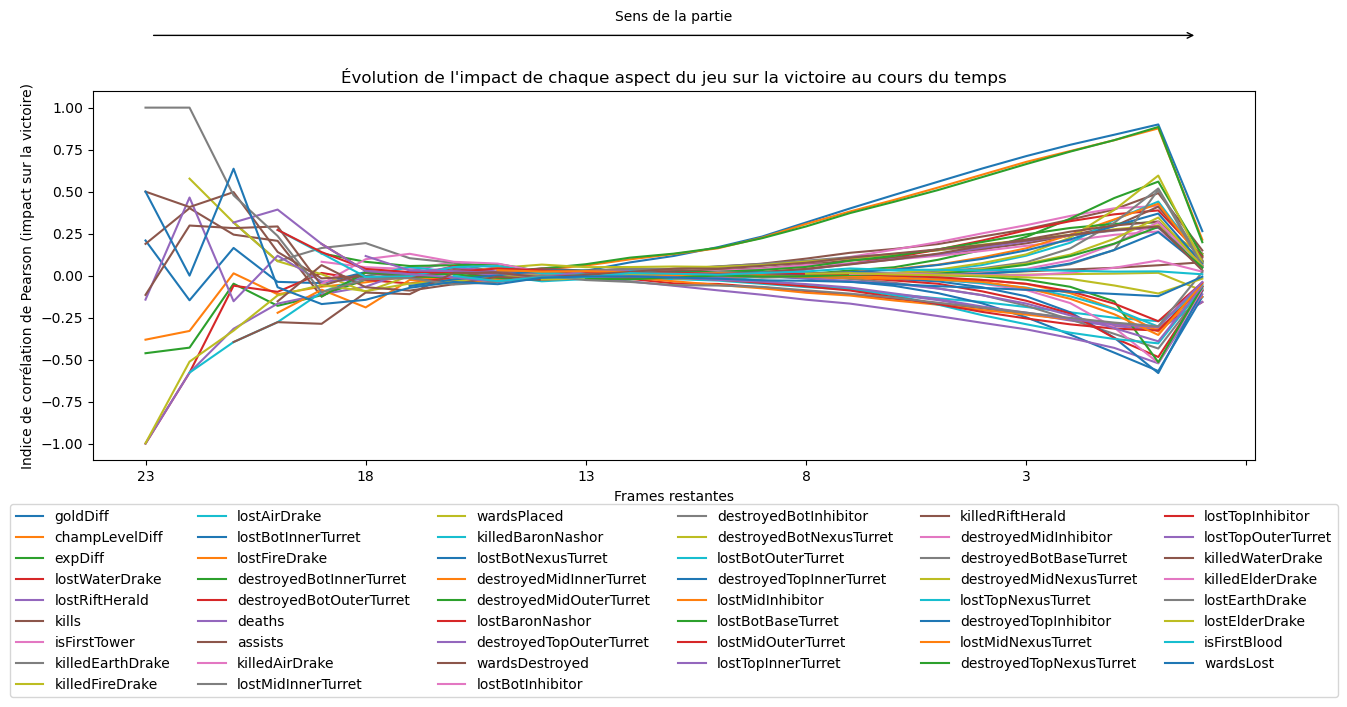

In [17]:
# Create the plot
correlation_matrix.T.plot(
    figsize=(15, 4.8),
    title='Évolution de l\'impact de chaque aspect du jeu sur la victoire au cours du temps',
    xlabel='Frames restantes',
    ylabel='Indice de corrélation de Pearson (impact sur la victoire)'
)

plt.annotate('Sens de la partie', xy=(0.5, 1.2), xycoords='axes fraction', 
             ha='center', va='center', fontsize=10)
plt.annotate(None, xy=(0.95, 1.15), xycoords='axes fraction',
             xytext=(0.05, 1.15), 
             arrowprops=dict(arrowstyle='->'))

# Add legend below the plot
plt.legend(bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=6)

Il ne faut pas oublier que toutes les parties n'ont pas le même nombre de frames. Pour un nombre de frames très grand (ex : 56), le nombre de parties est très faible et donc moins représentatif. On peut vérifier cela en regardant la distribution du nombre de frames restantes par partie. Cela peut potentiellement expliquer la dispertion étrange de la corrélation sur les frames très grandes.

In [18]:
df.groupby('remaining_frames').gameId.nunique()

remaining_frames
0     24912
1     24842
2     24716
3     24502
4     23430
5     22632
6     20951
7     18818
8     16086
9     12985
10     9937
11     7101
12     4749
13     2985
14     1838
15     1013
16      557
17      283
18      132
19       62
20       25
21        9
22        4
23        3
Name: gameId, dtype: int64

Seul 3 parties ont 23 frames dans le jeu de données tandis que 22632 en ont 5. On comprend donc que certaines corrélation ne sont pas représentatives au vu du nombre de parties. On enlève donc les frames contenant moins de 50 parties (on ne garde donc que les frames inférieures ou égales à 19).

In [19]:
correlation_matrix.drop([20,21,22,23,'mean'], axis=1, inplace=True) # on supprime également la colonne 'mean' car les valeurs de celle-ci vont changer avec les colonnes supprimées
assert correlation_matrix.shape[1] == 20, 'Il y a un problème dans la suppression des colonnes' # 0 à 19 frames restantes
print('Les colonnes ont bien été supprimées !')

# rajout de la colonne 'mean' après suppression des colonnes
correlation_matrix['mean'] = correlation_matrix.mean(axis=1)
correlation_matrix = correlation_matrix.reindex(
    correlation_matrix['mean'].abs().sort_values(ascending=False).index
)
correlation_matrix

Les colonnes ont bien été supprimées !


,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,mean
goldDiff,-0.04,0.02,-0.01,-0.03,-0.02,0.01,0.03,0.08,0.12,0.17,0.23,0.32,0.40,0.48,0.56,0.64,0.71,0.78,0.84,0.90,0.31
champLevelDiff,-0.07,-0.04,-0.01,-0.03,0.01,0.04,0.06,0.10,0.13,0.16,0.23,0.31,0.38,0.45,0.52,0.60,0.68,0.74,0.81,0.88,0.30
expDiff,-0.12,-0.02,-0.01,-0.01,0.02,0.04,0.07,0.11,0.13,0.17,0.22,0.29,0.37,0.44,0.51,0.59,0.66,0.74,0.81,0.88,0.29
deaths,-0.04,-0.02,0.01,0.05,0.02,0.01,-0.02,-0.03,-0.06,-0.09,-0.11,-0.14,-0.17,-0.20,-0.24,-0.28,-0.32,-0.37,-0.43,-0.52,-0.15
isFirstTower,0.08,0.05,0.04,0.08,0.01,0.01,-0.01,0.00,0.03,0.03,0.04,0.07,0.11,0.15,0.20,0.25,0.30,0.36,0.40,0.41,0.13
kills,-0.12,0.02,0.01,0.04,0.02,0.04,0.03,0.04,0.04,0.05,0.07,0.10,0.14,0.16,0.19,0.23,0.28,0.33,0.39,0.49,0.13
lostBotInnerTurret,NaN,NaN,NaN,NaN,-0.03,-0.01,-0.00,0.00,0.01,0.02,-0.00,-0.02,-0.04,-0.06,-0.10,-0.17,-0.25,-0.35,-0.46,-0.57,-0.13
killedEarthDrake,0.16,0.19,0.10,0.08,0.02,0.02,0.03,0.04,0.04,0.06,0.07,0.09,0.11,0.13,0.15,0.18,0.21,0.24,0.27,0.29,0.12
lostFireDrake,-0.08,-0.19,-0.03,-0.05,-0.02,-0.02,-0.01,-0.01,-0.03,-0.06,-0.08,-0.10,-0.12,-0.15,-0.17,-0.20,-0.23,-0.26,-0.29,-0.31,-0.12
destroyedBotInnerTurret,0.13,0.08,0.06,0.06,0.07,0.03,0.03,0.01,0.00,-0.00,0.00,0.01,0.03,0.05,0.09,0.15,0.23,0.34,0.46,0.56,0.12


Étudions la répartition des corrélation pour voir si certaines features se démarquent.

<Axes: >

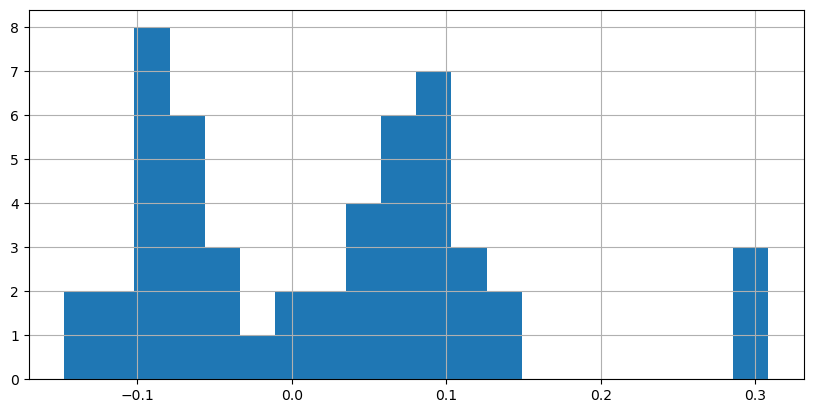

In [20]:
correlation_matrix['mean'].hist(bins=20)

In [21]:
correlation_matrix.head(3)

,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,mean
goldDiff,-0.04,0.02,-0.01,-0.03,-0.02,0.01,0.03,0.08,0.12,0.17,0.23,0.32,0.40,0.48,0.56,0.64,0.71,0.78,0.84,0.90,0.31
champLevelDiff,-0.07,-0.04,-0.01,-0.03,0.01,0.04,0.06,0.10,0.13,0.16,0.23,0.31,0.38,0.45,0.52,0.60,0.68,0.74,0.81,0.88,0.30
expDiff,-0.12,-0.02,-0.01,-0.01,0.02,0.04,0.07,0.11,0.13,0.17,0.22,0.29,0.37,0.44,0.51,0.59,0.66,0.74,0.81,0.88,0.29


On constate que 3 features se démarquent (`goldDiff`, `champLevelDiff` et `expDiff`) avec une corrélation moyenne de 0,3. En réalité `champLevelDiff` et `expDiff` correspondent au même aspect du jeu (quantité d'expérience gagnée) sauf que `champLevelDiff` compte la différence des niveaux de champion tandis que `expDiff` compte la différence d'expérience. Elles correspondent à la même chose car c'est l'expérience qui fait monter de niveau les champions.

Nous savons donc que l'or et l'expérience sont les 2 aspects du jeu qui ont le plus d'impact sur la victoire ce qui n'est pas surprenant.

On va tout de même essayer d'analyser les différences de ressources entre gagnants et perdants.

([<matplotlib.axis.XTick at 0x32af95b10>,
 [Text(0, 0, 'Défaite'), Text(1, 0, 'Victoire')])

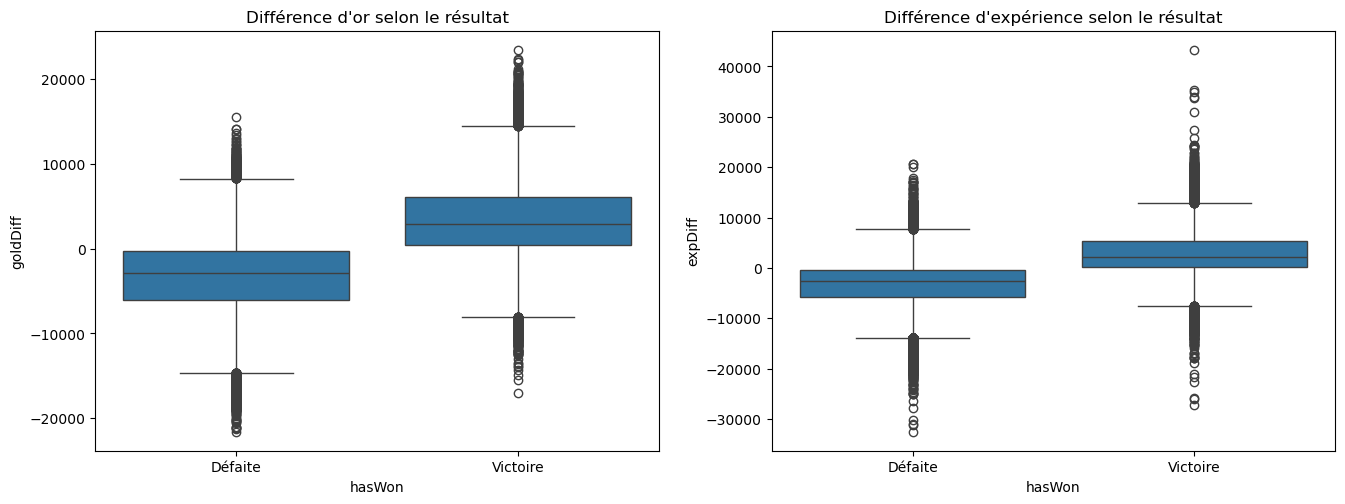

In [22]:
plt.figure(figsize=(16, 12))

plt.subplot(2, 2, 1)
sns.boxplot(data=df, x='hasWon', y='goldDiff')
plt.title('Différence d\'or selon le résultat')
plt.xticks([0, 1], ['Défaite', 'Victoire'])

plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='hasWon', y='expDiff')
plt.title('Différence d\'expérience selon le résultat')
plt.xticks([0, 1], ['Défaite', 'Victoire'])

On va maintenant essayer de regarder si on peut trouver des patterns ou des choses intéressantes dans les corrélation. Pour cela, on va regarder les corrélation par type de feature (tourelles, dragons, wards, etc.)

In [23]:
# séparation des features en 4 catégories
batiments = [feature for feature in correlation_matrix.index if ('Turret' in feature) or ('Inhibitor' in feature)]
objectifs_neutres = [feature for feature in correlation_matrix.index if ('Drake' in feature) or ('RiftHerald' in feature) or ('BaronNashor' in feature)]
vision = [feature for feature in correlation_matrix.index if 'wards' in feature]
autres = [feature for feature in correlation_matrix.index if feature not in batiments + objectifs_neutres + vision]

# vérification que toutes les features sont bien dans une catégorie et une seule (1 catégorie par feature et aucune feature non catégorisée)
assert len(set(batiments + objectifs_neutres + vision + autres)) == len(correlation_matrix.index), 'Certaines features n\'ont pas été catégorisées'
assert len(set(batiments) & set(objectifs_neutres) & set(vision) & set(autres)) == 0, 'Certaines features ont été catégorisées dans plusieurs catégories'
print('Les features ont bien été catégorisées !')

Les features ont bien été catégorisées !


In [24]:
for cat_name, cat_list in zip(
    ['batiments', 'objectifs_neutres', 'vision', 'autres'], 
    [batiments, objectifs_neutres, vision, autres]
):
    print(f'{cat_name} : {len(cat_list)} features')
    temp_df = correlation_matrix.loc[cat_list]
    print(f'Moyenne des corrélations : {temp_df.mean().mean():.1e}')
    display(temp_df)

batiments : 26 features
Moyenne des corrélations : 7.9e-03


,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,mean
lostBotInnerTurret,NaN,NaN,NaN,NaN,-0.03,-0.01,-0.00,0.00,0.01,0.02,-0.00,-0.02,-0.04,-0.06,-0.10,-0.17,-0.25,-0.35,-0.46,-0.57,-0.13
destroyedBotInnerTurret,0.13,0.08,0.06,0.06,0.07,0.03,0.03,0.01,0.00,-0.00,0.00,0.01,0.03,0.05,0.09,0.15,0.23,0.34,0.46,0.56,0.12
destroyedBotOuterTurret,0.19,0.03,-0.01,0.06,0.00,0.01,-0.01,0.01,0.01,0.02,0.02,0.04,0.07,0.11,0.16,0.21,0.27,0.32,0.36,0.39,0.11
lostMidInnerTurret,NaN,NaN,NaN,NaN,0.00,0.02,-0.01,-0.02,0.01,0.01,-0.00,-0.00,-0.02,-0.04,-0.08,-0.12,-0.18,-0.26,-0.35,-0.43,-0.09
lostBotOuterTurret,0.13,-0.01,-0.00,0.05,0.06,0.01,0.01,0.02,0.00,-0.01,-0.03,-0.06,-0.08,-0.12,-0.17,-0.24,-0.29,-0.34,-0.38,-0.40,-0.09
lostBotNexusTurret,NaN,NaN,NaN,NaN,-0.03,-0.02,-0.02,0.01,0.02,0.02,0.02,0.00,-0.00,-0.02,-0.03,-0.07,-0.12,-0.22,-0.37,-0.58,-0.09
destroyedMidInnerTurret,NaN,NaN,NaN,NaN,-0.02,-0.01,0.00,0.01,0.01,0.00,0.00,0.01,0.02,0.04,0.07,0.11,0.16,0.24,0.33,0.43,0.09
destroyedMidOuterTurret,-0.12,0.02,0.01,0.01,-0.01,-0.02,-0.02,-0.00,0.02,0.02,0.03,0.05,0.09,0.12,0.16,0.20,0.25,0.28,0.31,0.32,0.09
destroyedTopOuterTurret,NaN,0.03,0.02,0.03,0.00,0.01,-0.01,-0.01,0.00,0.00,0.00,0.04,0.07,0.10,0.13,0.17,0.20,0.24,0.27,0.28,0.08
lostMidOuterTurret,0.14,0.04,0.02,0.02,0.04,0.03,0.02,0.02,-0.01,-0.02,-0.04,-0.06,-0.09,-0.13,-0.17,-0.22,-0.25,-0.29,-0.32,-0.33,-0.08


objectifs_neutres : 14 features
Moyenne des corrélations : -4.3e-03


,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,mean
killedEarthDrake,0.16,0.19,0.10,0.08,0.02,0.02,0.03,0.04,0.04,0.06,0.07,0.09,0.11,0.13,0.15,0.18,0.21,0.24,0.27,0.29,0.12
lostFireDrake,-0.08,-0.19,-0.03,-0.05,-0.02,-0.02,-0.01,-0.01,-0.03,-0.06,-0.08,-0.10,-0.12,-0.15,-0.17,-0.20,-0.23,-0.26,-0.29,-0.31,-0.12
lostEarthDrake,-0.10,-0.02,-0.01,-0.05,-0.04,-0.00,-0.03,-0.04,-0.06,-0.06,-0.07,-0.09,-0.11,-0.13,-0.16,-0.19,-0.22,-0.25,-0.28,-0.30,-0.11
lostWaterDrake,0.02,-0.03,-0.05,-0.01,-0.01,-0.01,0.00,-0.02,-0.05,-0.05,-0.07,-0.09,-0.11,-0.14,-0.16,-0.19,-0.23,-0.26,-0.29,-0.31,-0.10
killedFireDrake,0.01,-0.10,-0.00,0.02,0.05,0.07,0.05,0.05,0.05,0.05,0.06,0.08,0.10,0.13,0.15,0.18,0.21,0.24,0.28,0.30,0.10
killedAirDrake,-0.05,0.10,0.13,0.08,0.07,0.02,0.01,0.00,0.01,0.03,0.04,0.06,0.07,0.10,0.12,0.15,0.18,0.21,0.24,0.26,0.09
killedBaronNashor,NaN,NaN,NaN,NaN,NaN,NaN,0.03,0.03,0.00,-0.01,-0.00,-0.00,0.01,0.02,0.03,0.06,0.12,0.20,0.33,0.44,0.09
lostRiftHerald,-0.11,-0.07,0.03,0.08,0.05,0.03,0.03,0.02,0.00,-0.02,-0.03,-0.06,-0.08,-0.11,-0.15,-0.19,-0.22,-0.27,-0.30,-0.32,-0.08
lostBaronNashor,NaN,NaN,NaN,NaN,0.03,0.03,-0.01,-0.00,0.00,0.00,-0.00,-0.00,-0.01,-0.03,-0.05,-0.09,-0.15,-0.23,-0.37,-0.48,-0.08
lostAirDrake,-0.10,-0.00,0.05,0.02,-0.00,-0.03,-0.02,-0.02,-0.02,-0.03,-0.05,-0.07,-0.08,-0.11,-0.14,-0.16,-0.19,-0.22,-0.25,-0.27,-0.08


vision : 3 features
Moyenne des corrélations : -1.8e-02


,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,mean
wardsLost,-0.17,-0.14,-0.07,-0.04,-0.05,-0.01,-0.00,-0.00,-0.01,-0.02,-0.03,-0.03,-0.04,-0.05,-0.06,-0.07,-0.08,-0.10,-0.11,-0.12,-0.06
wardsDestroyed,-0.02,-0.00,-0.01,0.03,0.02,0.04,0.02,0.02,0.01,0.01,0.01,0.00,0.01,0.01,0.01,0.02,0.03,0.04,0.05,0.06,0.02
wardsPlaced,-0.06,-0.09,-0.05,-0.03,-0.01,-0.01,-0.01,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.01,0.02,-0.01


autres : 8 features
Moyenne des corrélations : 1.4e-01


,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0,mean
goldDiff,-0.04,0.02,-0.01,-0.03,-0.02,0.01,0.03,0.08,0.12,0.17,0.23,0.32,0.40,0.48,0.56,0.64,0.71,0.78,0.84,0.90,0.31
champLevelDiff,-0.07,-0.04,-0.01,-0.03,0.01,0.04,0.06,0.10,0.13,0.16,0.23,0.31,0.38,0.45,0.52,0.60,0.68,0.74,0.81,0.88,0.30
expDiff,-0.12,-0.02,-0.01,-0.01,0.02,0.04,0.07,0.11,0.13,0.17,0.22,0.29,0.37,0.44,0.51,0.59,0.66,0.74,0.81,0.88,0.29
deaths,-0.04,-0.02,0.01,0.05,0.02,0.01,-0.02,-0.03,-0.06,-0.09,-0.11,-0.14,-0.17,-0.20,-0.24,-0.28,-0.32,-0.37,-0.43,-0.52,-0.15
isFirstTower,0.08,0.05,0.04,0.08,0.01,0.01,-0.01,0.00,0.03,0.03,0.04,0.07,0.11,0.15,0.20,0.25,0.30,0.36,0.40,0.41,0.13
kills,-0.12,0.02,0.01,0.04,0.02,0.04,0.03,0.04,0.04,0.05,0.07,0.10,0.14,0.16,0.19,0.23,0.28,0.33,0.39,0.49,0.13
assists,-0.06,0.02,-0.01,0.02,-0.01,0.02,0.01,0.03,0.03,0.03,0.04,0.06,0.09,0.11,0.13,0.16,0.19,0.24,0.29,0.41,0.09
isFirstBlood,-0.13,NaN,NaN,-0.00,-0.03,-0.01,-0.01,0.01,0.01,0.01,0.02,0.02,0.04,0.03,0.04,0.03,0.04,0.03,0.02,0.03,0.01


Conlusion :

- **Tourelles et inhibiteurs (3ème en corrélation moyenne)** : Il semble que toutes les tourelles n'aient pas le même impact sur la victoire. En effet, les features liées à la tourelle bot ont une corrélation plus élevée que les autres. Cette supposition nécessite une vérification plus approfondie (groupement des tourelles par lane puis barplot de la corrélation en attribuant une couleur différente à chaque lane pour bien visualiser les différences).

- **Objectifs neutres (4ème en corrélation moyenne)** : Rien de notable dans les corrélations entre les différents types de dragons basiques (terre, feu, eau, air) et l'hérald. On pourra éventuellement réaliser un comparatif de ces différents objectifs entre eux dans le futur. On remarque cependant une corrélation moyenne faible du Baron Nashor et de l'Elder Dragon qui sont normalement des objectifs décisifs pour la victoire. On va enquêter pour comprendre pourquoi.

- **Wards (2ème en corrélation moyenne)** : Les wards ont un impact faible sur la victoire en comparaison avec les autres aspects du jeu. Cela peut paraître étrange lorsque l'on sait que les wards sont un aspect très important dans les parties professionnelles. Cela peut donc s'expliquer par le fait que ce sont ici des parties de niveau platine et que les joueurs ne savent pas forcément comment utiliser les wards de manière optimale (placement). On peut également supposer que les joueurs ne savent pas comment utiliser les informations données par les wards pour prendre des décisions stratégiques ou encore que les joueurs ne regardent pas suffisamment la minimap pour voir les ennemis. Il serait intéressant de regarder la corrélation entre les wards et la victoire sur d'autres jeux de données à différents niveaux de jeu pour voir si cette corrélation augmente avec le niveau de jeu.

- **Autres (1er en corrélation moyenne)** : Catégorie difficilement interprétable car elle regroupe des features n'appartenant pas aux autres catégories.

<h2 id='lanes'>Les lanes ont-elles un impact différent sur la victoire ?</h2>

Pour approfondir l'analyse, on va commencer par regarder la corrélation des tourelles par lane.

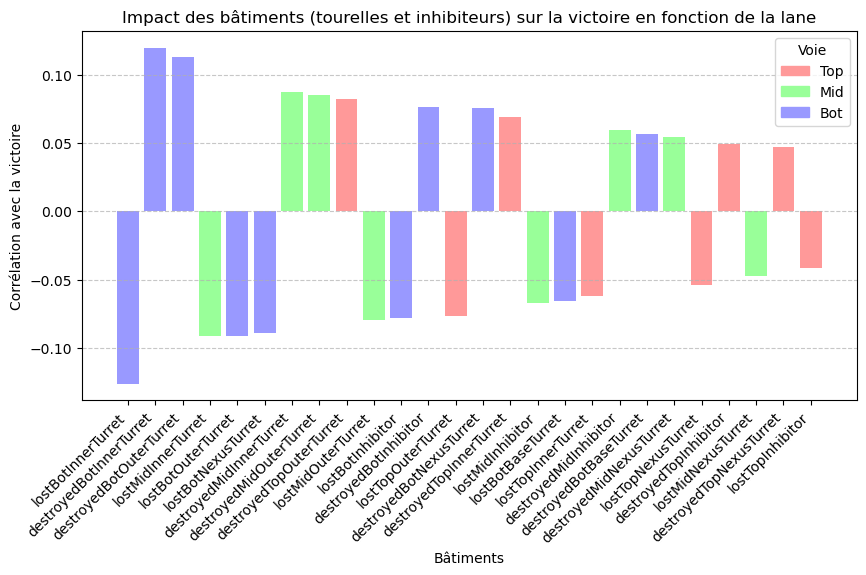

In [25]:
batiments_corr = correlation_matrix.loc[batiments, 'mean']
batiments_corr = batiments_corr.reindex(batiments_corr.abs().sort_values(ascending=False).index)

plt.figure()

for i, (turret, corr) in enumerate(batiments_corr.items()):

    if 'Top' in turret:
        plt.bar(i, corr, color='#FF9999', label='Top')    
    elif 'Mid' in turret:
        plt.bar(i, corr, color='#99FF99', label='Mid')
    else:
        plt.bar(i, corr, color='#9999FF', label='Bot')

# Customize the plot
plt.title('Impact des bâtiments (tourelles et inhibiteurs) sur la victoire en fonction de la lane')
plt.xlabel('Bâtiments')
plt.ylabel('Corrélation avec la victoire')
plt.xticks(range(len(batiments_corr)), batiments_corr.index, rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(handles=[
    plt.Rectangle((0,0),1,1, color='#FF9999', label='Top'),
    plt.Rectangle((0,0),1,1, color='#99FF99', label='Mid'),
    plt.Rectangle((0,0),1,1, color='#9999FF', label='Bot')
], title='Voie', loc='upper right')

Ce graphique nous permet clairement de voir que les batiments bot (particulièrement les tourelles devant les inhibiteurs) ont un impact plus important sur la victoire que les autres tourelles. Les tourelles top semblent avoir un impact plus faible que les tourelles mid.

On va chiffrer l'importance de chaque lane en regardant leur impact individuel par rapport à l'impact global des tourelles.

In [26]:
# séparation des tourelles détruites par voie
destroyed_bat = batiments_corr[batiments_corr.index.str.contains('destroyed')]

top_destroyed_bat = destroyed_bat[destroyed_bat.index.str.contains('Top')]
mid_destroyed_bat = destroyed_bat[destroyed_bat.index.str.contains('Mid')]
bot_destroyed_bat = destroyed_bat[destroyed_bat.index.str.contains('Bot')]

assert set(destroyed_bat.index) == set(top_destroyed_bat.index) | set(mid_destroyed_bat.index) | set(bot_destroyed_bat.index), 'Il y a un problème dans la séparation des tourelles détruites par voie'

# calcul de l'impact de chaque lane par raport à l'impact de toutes les lanes
all_lanes_mean = bot_destroyed_bat.mean() + mid_destroyed_bat.mean() + top_destroyed_bat.mean()

bot_importance = bot_destroyed_bat.mean() / all_lanes_mean
mid_importance = mid_destroyed_bat.mean() / all_lanes_mean
top_importance = top_destroyed_bat.mean() / all_lanes_mean

assert top_importance + mid_importance + bot_importance == 1, 'Il y a un problème dans le calcul de l\'importance des tourelles détruites par voie'

# résultats
print(f'Importance des tourelles détruites par voie :')
print(f'Top : {top_importance:.0%}')
print(f'Mid : {mid_importance:.0%}')
print(f'Bot : {bot_importance:.0%}')

Importance des tourelles détruites par voie :
Top : 28%
Mid : 32%
Bot : 40%


<h2 id='objectifs'>Les objectifs ont-ils un impact différent sur la victoire ?</h2>

Tout bon joueur de League of Legends sait que les objectifs neutres (dragons, baron, hérald) sont des éléments clés pour gagner une partie. On va donc regarder quel est l'impact de ces objectifs sur la victoire.

On peut maintenant regarder la corrélation des dragons entre eux et étudier le manque d'impact du Baron Nashor et de l'Elder Dragon.

Étant donné que nous allons maintenant effectuer des prédictions, on ne peut plus utiliser la feature `remaining_frames` qui est une information qui n'est pas supposée être connue à l'avance. À la place, on va utiliser la feature `frame` qui correspond à la frame actuelle du jeu.

Le premier dragon apparaît à 5 minutes de jeu, et la prochaine apparition dépend du précédent. Par exemple, si on tue le premier dragon à 7 minutes de jeu, le suivant apparaîtra à 12 minutes. (5 min entre chaque apparition). On va donc effectuer la prédiction à 20 minutes de jeu (frame=20) car c'est à partir de ce moment qu'une équipe peut avoir le maximum de dragons (4).

In [27]:
drake_df = df[df.frame==20][[feature for feature in df.columns if 'Drake' in feature] + ['hasWon']].reset_index(drop=True)

# diff = dragons gagnés - dragons perdus
drake_df['earthDrakeDiff'] = drake_df.killedEarthDrake - drake_df.lostEarthDrake
drake_df['fireDrakeDiff'] = drake_df.killedFireDrake - drake_df.lostFireDrake
drake_df['waterDrakeDiff'] = drake_df.killedWaterDrake - drake_df.lostWaterDrake
drake_df['airDrakeDiff'] = drake_df.killedAirDrake - drake_df.lostAirDrake

In [28]:
drake_df = drake_df[[feature for feature in drake_df.columns if 'Diff' in feature] + ['hasWon']]

# features et target
X = drake_df.drop('hasWon', axis=1) # pas besoin de standardiser car on compare des différences de drakes (la même unité)
y = drake_df['hasWon']

# modèle
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X, y)

# résultats
print(f'Accuracy du modèle: {logistic_model.score(X, y):.2%}')
pd.Series(logistic_model.coef_[0], index=X.columns).sort_values(ascending=False)

Accuracy du modèle: 70.79%


fireDrakeDiff    0.67
waterDrakeDiff   0.67
earthDrakeDiff   0.66
airDrakeDiff     0.53
dtype: float64

Text(95.72222222222221, 0.5, 'Vérité')

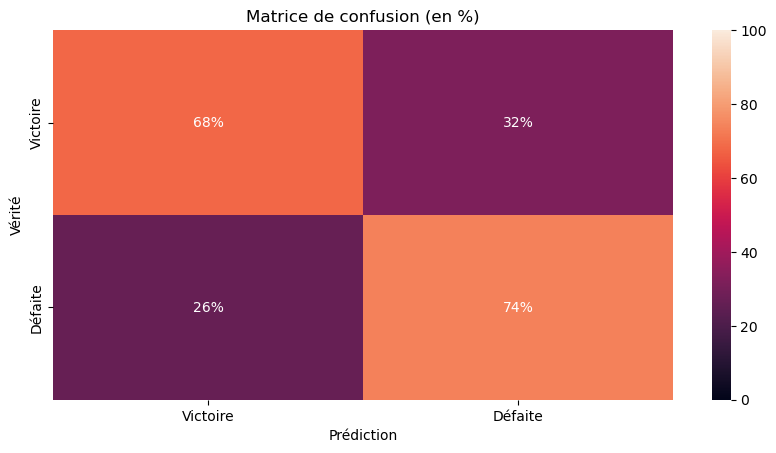

In [29]:
plt.figure()

sns.heatmap(
    (confusion_matrix(y, logistic_model.predict(X), normalize='true'))*100,
    vmin=0,
    vmax=100,
    annot=True,
    xticklabels=['Victoire', 'Défaite'],
    yticklabels=['Victoire', 'Défaite']
)

for i, text in enumerate(plt.gca().texts):
    text.set_text(f"{text.get_text()}%")

plt.title('Matrice de confusion (en %)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')

Actuellement, on prédit correctement 68% des victoires et 74% des défaites. On va essayer d'optimiser les hyperparamètres de notre modèle pour obtenir les meilleures performances possibles.

In [30]:
param_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'], # pénalisation : évite l'overfitting --> l1 (Lasso), l2 (Ridge) ou les deux (ElasticNet)
    'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1], # inverse de régularisation : évite l'underfitting --> plus C est grand, moins la régularisation est forte
}

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=logistic_model,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    verbose=0
)

grid_search.fit(X, y)
optimal_logistic_model = grid_search.best_estimator_

# résultats grid search
print(f'Meilleurs hyperparamètres: {grid_search.best_params_}')

# résultats du modèle
print(f'Accuracy du modèle: {(optimal_logistic_model.score(X, y)):.0%}')

Meilleurs hyperparamètres: {'C': 0.0001, 'penalty': 'l2'}
Accuracy du modèle: 71%


L'optimisation ne change rien (accuracy=71% dans les 2 cas). On garde le modèle initial.

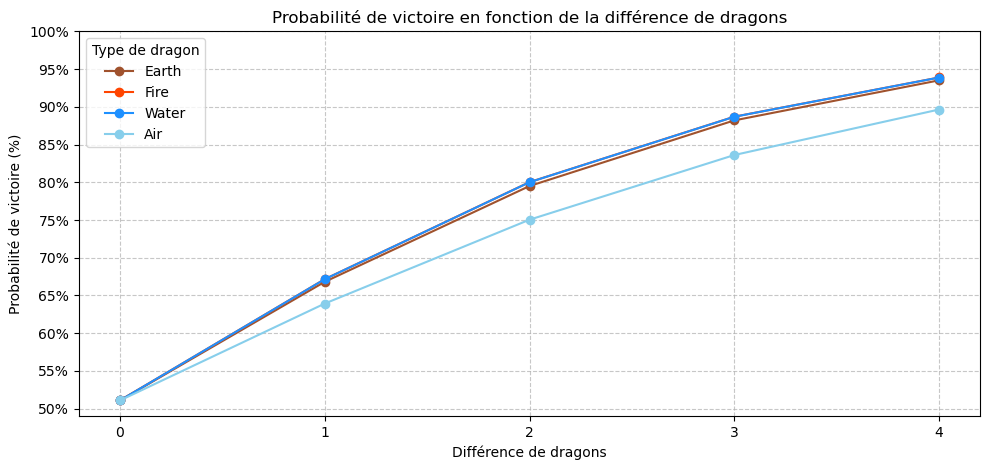

In [31]:
drake_diffs = np.arange(0, 5) # on ne s'intéresse qu'aux valeurs positives car il y a une symétrie (car pas d'égalité possible dans le jeu)
drake_win_probs = {'Earth': [], 'Fire': [], 'Water': [], 'Air': []}
drake_colors = {'Earth': '#A0522D', 'Fire': '#FF4500', 'Water': '#1E90FF', 'Air': '#87CEEB'}

for drake_name, drake_feature in zip(
    ['Earth', 'Fire', 'Water', 'Air'],
    ['earthDrakeDiff', 'fireDrakeDiff', 'waterDrakeDiff', 'airDrakeDiff']
):
    probs = []
    for diff in drake_diffs:
        # sceanrio où 1 les valeurs varient pour 1 seul type de dragon
        test_scenario = np.zeros((1, 4)) # terre, feu, eau, air
        
        # Set the appropriate drake difference in the test scenario
        if drake_feature == 'earthDrakeDiff':
            test_scenario[0, 0] = diff
        elif drake_feature == 'fireDrakeDiff':
            test_scenario[0, 1] = diff
        elif drake_feature == 'waterDrakeDiff':
            test_scenario[0, 2] = diff
        elif drake_feature == 'airDrakeDiff':
            test_scenario[0, 3] = diff
            
        win_prob = logistic_model.predict_proba(test_scenario)[0, 1] # probabilité de victoire
        probs.append(win_prob*100)
    
    drake_win_probs[drake_name] = probs


plt.figure()
plt.title('Probabilité de victoire en fonction de la différence de dragons')
plt.xlabel('Différence de dragons')
plt.xticks(drake_diffs)
plt.ylabel('Probabilité de victoire (%)')
plt.yticks(range(50, 101, 5), [f"{i}%" for i in range(50, 101, 5)])
plt.ylim(49, 100)

for drake_name, probs in drake_win_probs.items():
    plt.plot(drake_diffs, probs, marker='o', label=drake_name, color=drake_colors[drake_name])

plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(title='Type de dragon', loc='upper left')

plt.tight_layout()
plt.show()

On constate qu'il n'y a pas de grandes différences d'impact entre les dragons de terre, de feu et d'eau. Cependant, le dragon d'air a un impact plus faible que les autres dragons.

In [32]:
earth_drake_impact = np.mean(drake_win_probs['Earth'])
fire_drake_impact = np.mean(drake_win_probs['Fire'])
water_drake_impact = np.mean(drake_win_probs['Water'])
air_drake_impact = np.mean(drake_win_probs['Air'])

tot = earth_drake_impact + fire_drake_impact + water_drake_impact + air_drake_impact

print(f'Impact des dragons sur la victoire :')
print(f'Terre : {earth_drake_impact/tot:.0%}')
print(f'Feu : {fire_drake_impact/tot:.0%}')
print(f'Eau : {water_drake_impact/tot:.0%}')
print(f'Air : {air_drake_impact/tot:.0%}')

Impact des dragons sur la victoire :
Terre : 25%
Feu : 25%
Eau : 25%
Air : 24%


On va maintenant étudier pourquoi l'impact de l'Elder Dragon et du Baron Nashor est semblait faible lors de l'analyse des corrélations.

In [33]:
[feature for feature in df.columns if 'Elder' in feature]

['killedElderDrake', 'lostElderDrake']

In [34]:
# on récupère les games où l'elder drake a été tué au moins une fois
elder_per_game = df.groupby('gameId')[['killedElderDrake', 'lostElderDrake']].max().reset_index() # max d'Elder tué par partie
df[df.gameId.isin(
    elder_per_game[(elder_per_game.killedElderDrake == 1) | (elder_per_game.lostElderDrake == 1)].gameId
)][['gameId', 'hasWon', 'frame', 'killedElderDrake', 'lostElderDrake']].head(42) # parties où l'Elder a été tué au moins une fois

,gameId,hasWon,frame,killedElderDrake,lostElderDrake
2215,4529499761,True,10,0,0
2216,4529499761,True,12,0,0
2217,4529499761,True,14,0,0
2218,4529499761,True,16,0,0
2219,4529499761,True,18,0,0
2220,4529499761,True,20,0,0
2221,4529499761,True,22,0,0
2222,4529499761,True,24,0,0
2223,4529499761,True,26,0,0
2224,4529499761,True,28,0,0


Le DataFrame ci-dessus représente 3 parties où l'Elder Dragon a été tué :
1. L'équipe rouge récupère l'Elder Dragon à la frame 32 et perd la partie à la frame 38.
2. L'équipe rouge récupère l'Elder Dragon à la frame 34 et gagne la partie à la frame 34.
3. L'équipe bleue récupère l'Elder Dragon à la frame 32 et gagne la partie à la frame 36.

On a donc 1 équipe sur 3 qui perd malgré l'Elder Dragon. Et dans les 2 cas où l'équipe gagne après avoir pris l'Elder Dragon, la partie ne se termine pas forcément juste après (directement dans le cas 2 mais 4 frames après dans le cas 3).

C'est étrange car l'Elder Dragon est censé être l'objectif le plus puissant du jeu (côte à côte avec le Baron Nashor). Il applique des dégâts de brûlure sur la durée et éxécute les ennemis en dessous de 20% de leurs PV (buffs vraiment puissants). On chercher donc à comprendre pourquoi l'Elder Dragon n'a pas un impact plus fort sur la victoire.

In [35]:
print(f"{(df[(df.killedElderDrake!=0) | (df.lostElderDrake!=0)].groupby('gameId').remaining_frames.max().mean()):.1f}")

1.1


Ce résultat est plus logique, on voit que les parties se terminent généralement très rapidement après la prise de l'Elder Dragon (1.1 frames en moyenne).

In [36]:
elder_df = df[(df.killedElderDrake!=0) | (df.lostElderDrake!=0)].groupby('gameId')[['hasWon', 'killedElderDrake', 'lostElderDrake', 'remaining_frames']].max()
elder_df['diffElderDrake'] = elder_df.killedElderDrake - elder_df.lostElderDrake
elder_corr = elder_df.corrwith(elder_df['hasWon']).get('diffElderDrake')
print(f"{elder_corr:.2f}")

0.66


On voit ici l'énorme impact du dragon ancestral sur la victoire avec une corrélation de 0.66 avec la victoire.

Comparons maintenant l'impact du Baron Nashor et de l'Elder Dragon sur la victoire.

In [37]:
nashor_df = df[(df.killedBaronNashor!=0) | (df.lostBaronNashor!=0)].groupby('gameId')[['hasWon', 'killedBaronNashor', 'lostBaronNashor', 'remaining_frames']].max()
nashor_df['diffBaronNashor'] = nashor_df.killedBaronNashor - nashor_df.lostBaronNashor
nashor_corr = nashor_df.corrwith(nashor_df['hasWon']).get('diffBaronNashor')
print(f"{nashor_corr:.2f}")

0.70


Le Nashor a donc un impact légèrement plus important que l'Elder Dragon sur la victoire (0.7 contre 0.66).

In [38]:
# comparaison des impacts de l'Elder Drake et du Baron Nashor
tot = elder_corr + nashor_corr
print(f'Elder Drake : {(elder_corr/(tot)):.0%}')
print(f'Baron Nashor : {(nashor_corr/(tot)):.0%}')

Elder Drake : 48%
Baron Nashor : 52%


<h1 id='machine-learning'>Machine Learning</h1>

Dans cette partie, nous allons tester et comparer plusieurs modèles de machine learning pour prédire la victoire de l'équipe bleue en fonction des différentes métriques du jeu disponibles.

On commence par créer un nouveau DataFrame (df_ml), plus optimisé pour le machine learning car il évite la redondance de certaines features.

In [39]:
df_ml = df[['gameId', 'hasWon', 'frame', 'goldDiff', 'expDiff', 'champLevelDiff', 'isFirstTower', 'isFirstBlood', 'kills', 'deaths', 'assists', 'wardsPlaced', 'wardsDestroyed', 'wardsLost']]

# objectifs neutres
## dragons
df_ml['earthDrakeDiff'] = df.killedEarthDrake - df.lostEarthDrake
df_ml['fireDrakeDiff'] = df.killedFireDrake - df.lostFireDrake
df_ml['waterDrakeDiff'] = df.killedWaterDrake - df.lostWaterDrake
df_ml['airDrakeDiff'] = df.killedAirDrake - df.lostAirDrake
df_ml['elderDrakeDiff'] = df.killedElderDrake - df.lostElderDrake
## rift herald et baron nashor
df_ml['riftHeraldDiff'] = df.killedRiftHerald - df.lostRiftHerald
df_ml['baronNashorDiff'] = df.killedBaronNashor - df.lostBaronNashor

# tourelles
## inhibitor
df_ml['topInhibitorDiff'] = df.destroyedTopInhibitor - df.lostTopInhibitor
df_ml['midInhibitorDiff'] = df.destroyedMidInhibitor - df.lostMidInhibitor
df_ml['botInhibitorDiff'] = df.destroyedBotInhibitor - df.lostBotInhibitor
## nexusTurret
df_ml['topBaseTurretDiff'] = df.destroyedTopNexusTurret - df.lostTopNexusTurret
df_ml['midBaseTurretDiff'] = df.destroyedMidNexusTurret - df.lostMidNexusTurret
df_ml['botBaseTurretDiff'] = df.destroyedBotNexusTurret - df.lostBotNexusTurret
## baseTurret (on a que la bot car problèmes avec les autres colonnes donc on prend en compte)
# df_ml['topBaseTurretDiff'] = df_ml.destroyedTopBaseTurret - df_ml.lostTopBaseTurret
## InnerTurret
df_ml['topInnerTurretDiff'] = df.destroyedTopInnerTurret - df.lostTopInnerTurret
df_ml['midInnerTurretDiff'] = df.destroyedMidInnerTurret - df.lostMidInnerTurret
df_ml['botInnerTurretDiff'] = df.destroyedBotInnerTurret - df.lostBotInnerTurret
## OuterTurret
df_ml['topOuterTurretDiff'] = df.destroyedTopOuterTurret - df.lostTopOuterTurret
df_ml['midOuterTurretDiff'] = df.destroyedMidOuterTurret - df.lostMidOuterTurret
df_ml['botOuterTurretDiff'] = df.destroyedBotOuterTurret - df.lostBotOuterTurret

assert (df_ml.shape[1]-14)*2+14+3 == df.shape[1], 'Il y a un problème dans la création des colonnes'
# 14 colonnes importées directement depuis `df`
# df_ml.shape[1]-14 : nombre de colonnes de différences créées à partir des colonnes 'killed'/'destroyed' et 'lost'
# (df_ml.shape[1]-14)*2 : nombre de colonnes de `df` utilisées pour créer les colonnes de différences
# +14 : on rajoute les colonnes directement importées que l'on avait retranchées
# +3 : car `df` comprend `destroyedTopBaseTurret`, `lostTopBaseTurret` et `remaining_frames` qui ne sont pas utilisées dans `df_ml`
print('df_ml a bien été créé !')

df_ml a bien été créé !


In [40]:
PREDICTION_FRAME = 10

# features et target
X = df_ml[df_ml.frame==PREDICTION_FRAME].drop(['gameId', 'hasWon', 'frame'], axis=1)
y = df_ml[df_ml.frame==PREDICTION_FRAME]['hasWon']

# séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# normalisation des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models_accuracy = {}

<h2 id='logistic-regression'>Régression logistique</h3>

In [41]:
# modèle
logistic_model = LogisticRegression(max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# résultats
models_accuracy['Régression logistique'] = logistic_model.score(X_test_scaled, y_test)
print(f"Accuracy du modèle: {models_accuracy['Régression logistique']:.2%}")
print(f'Rapport de classification : \n{classification_report(y_test, logistic_model.predict(X_test_scaled))}')
pd.Series(logistic_model.coef_[0], index=X.columns).sort_values(ascending=False).head(10)

Accuracy du modèle: 72.17%
Rapport de classification : 
              precision    recall  f1-score   support

       False       0.72      0.71      0.72      3087
        True       0.72      0.73      0.73      3141

    accuracy                           0.72      6228
   macro avg       0.72      0.72      0.72      6228
weighted avg       0.72      0.72      0.72      6228



goldDiff             0.95
expDiff              0.51
botBaseTurretDiff    0.20
waterDrakeDiff       0.19
fireDrakeDiff        0.16
earthDrakeDiff       0.13
midInnerTurretDiff   0.12
botInhibitorDiff     0.11
airDrakeDiff         0.09
topBaseTurretDiff    0.06
dtype: float64

Text(95.72222222222221, 0.5, 'Vérité')

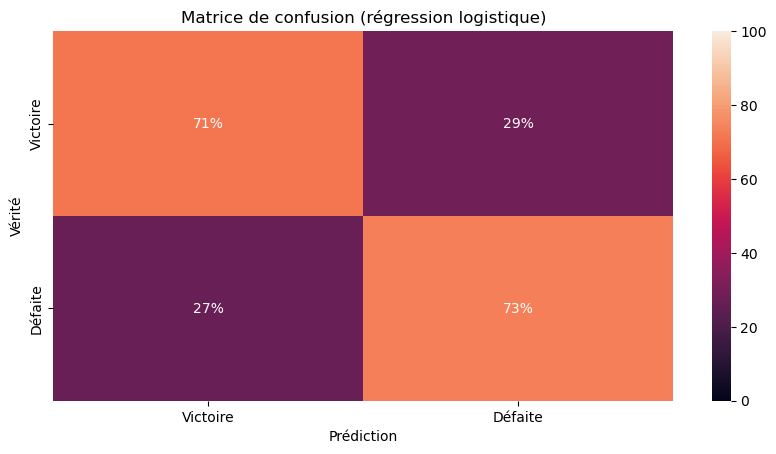

In [42]:
plt.figure()

sns.heatmap(
    (confusion_matrix(y_test, logistic_model.predict(X_test_scaled), normalize='true'))*100,
    vmin=0,
    vmax=100,
    annot=True,
    xticklabels=['Victoire', 'Défaite'],
    yticklabels=['Victoire', 'Défaite']
)

for i, text in enumerate(plt.gca().texts):
    text.set_text(f"{text.get_text()}%")

plt.title('Matrice de confusion (régression logistique)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')

Après avoir effectué plusieurs tests, l'optimisation d'hypérparamètres sur la régression logistique on se rend compte qu'en tentant d'optimiser C (inverse de la force de régularisation), le modèle attribue des importances de features très faibles à toutes les features afin de rendre les poids de toutes les features nulles sauf pour `goldDiff` et `expDiff` qui sont, comme nous l'avions vu précédemment lors de l'analyse des corrélations, les 2 features les plus importantes pour prédire la victoire.

On va donc faire un modèle de régression logistique avec uniquement ces 2 features à la place d'optimiser les hyperparamètres.

In [43]:
# on ne garde que 'goldDiff' et 'expDiff'
X_gold_exp = df_ml[df_ml.frame==PREDICTION_FRAME][['goldDiff', 'expDiff']]

# séparation des données
X_train_gold_exp, X_test_gold_exp, y_train_gold_exp, y_test_gold_exp = train_test_split(X_gold_exp, y, random_state=42)

# normalisation
X_train_gold_exp_scaled = scaler.fit_transform(X_train_gold_exp)
X_test_gold_exp_scaled = scaler.transform(X_test_gold_exp)

# entraînement
logistic_gold_exp_model = LogisticRegression(max_iter=1000)
logistic_gold_exp_model.fit(X_train_gold_exp_scaled, y_train_gold_exp)

# résultats
models_accuracy['Régression logistique (goldDiff et expDiff)'] = logistic_gold_exp_model.score(X_test_gold_exp_scaled, y_test_gold_exp)
print(f"Accuracy du modèle: {models_accuracy['Régression logistique (goldDiff et expDiff)']:.2%}")
print(f'Rapport de classification : \n{classification_report(y_test_gold_exp, logistic_gold_exp_model.predict(X_test_gold_exp_scaled))}')
pd.Series(logistic_gold_exp_model.coef_[0], index=X_gold_exp.columns).sort_values(ascending=False)

Accuracy du modèle: 71.37%
Rapport de classification : 
              precision    recall  f1-score   support

       False       0.71      0.71      0.71      3087
        True       0.71      0.72      0.72      3141

    accuracy                           0.71      6228
   macro avg       0.71      0.71      0.71      6228
weighted avg       0.71      0.71      0.71      6228



goldDiff   0.96
expDiff    0.53
dtype: float64

Text(95.72222222222221, 0.5, 'Vérité')

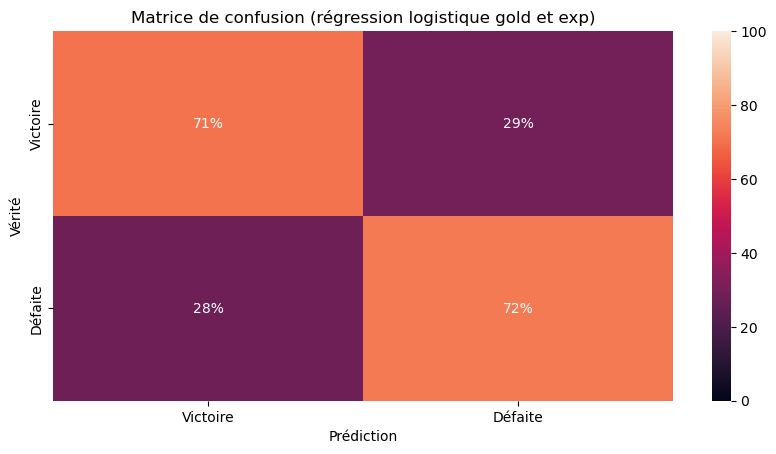

In [44]:
plt.figure()

sns.heatmap(
    (confusion_matrix(y_test_gold_exp, logistic_gold_exp_model.predict(X_test_gold_exp_scaled), normalize='true'))*100,
    vmin=0,
    vmax=100,
    annot=True,
    xticklabels=['Victoire', 'Défaite'],
    yticklabels=['Victoire', 'Défaite']
)

for i, text in enumerate(plt.gca().texts):
    text.set_text(f"{text.get_text()}%")

plt.title('Matrice de confusion (régression logistique gold et exp)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')

Malgré le fait que l'on garde uniquement ces 2 features, le modèle de base (sans optimisation) a tout de même de meilleures performances que le modèle optimisé avec toutes les features. De plus, la régression logistique n'est pas un modèle nécessitant beaucoup d'optimisation d'hypérparamètres.

<h2 id='knn'>K-Nearest Neighbors</h3>

In [45]:
knn_model = KNeighborsClassifier()
knn_model.fit(X_train_scaled, y_train)

models_accuracy['kNN'] = knn_model.score(X_test_scaled, y_test)
print(f"Accuracy du modèle: {models_accuracy['kNN']:.2%}")
print(f'Rapport de classification : \n{classification_report(y_test, knn_model.predict(X_test_scaled))}')

Accuracy du modèle: 67.66%
Rapport de classification : 
              precision    recall  f1-score   support

       False       0.68      0.66      0.67      3087
        True       0.67      0.69      0.68      3141

    accuracy                           0.68      6228
   macro avg       0.68      0.68      0.68      6228
weighted avg       0.68      0.68      0.68      6228



Text(95.72222222222221, 0.5, 'Vérité')

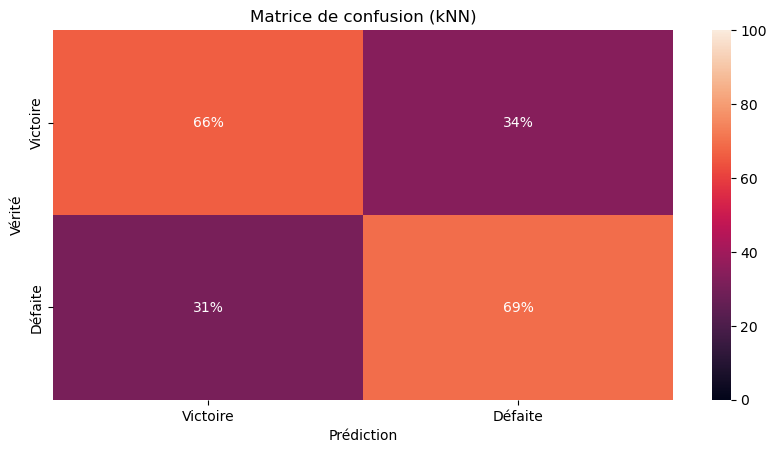

In [46]:
plt.figure()

sns.heatmap(
    (confusion_matrix(y_test, knn_model.predict(X_test_scaled), normalize='true'))*100,
    vmin=0,
    vmax=100,
    annot=True,
    xticklabels=['Victoire', 'Défaite'],
    yticklabels=['Victoire', 'Défaite']
)

for i, text in enumerate(plt.gca().texts):
    text.set_text(f"{text.get_text()}%")

plt.title('Matrice de confusion (kNN)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')

In [47]:
param_grid = {
    'n_neighbors': [2850, 2875, 2925], # k (nombre de voisins)
    'weights': ['uniform', 'distance'], # poids des voisins
    'metric': ['euclidean', 'manhattan', 'minkowski'] # distance entre les points
}

grid_search = GridSearchCV(
    estimator=knn_model,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    verbose=0
)

grid_search.fit(X_train_scaled, y_train)
optimal_knn_model = grid_search.best_estimator_

# résultats grid search
print(f'Meilleurs hyperparamètres: {grid_search.best_params_}')

# résultats du modèle
models_accuracy['kNN optimisé'] = optimal_knn_model.score(X_test_scaled, y_test)
print(f"Accuracy du modèle: {models_accuracy['kNN optimisé']:.2%}")
print(f'Rapport de classification : \n{classification_report(y_test, optimal_knn_model.predict(X_test_scaled))}')

Meilleurs hyperparamètres: {'metric': 'euclidean', 'n_neighbors': 2875, 'weights': 'distance'}
Accuracy du modèle: 71.36%
Rapport de classification : 
              precision    recall  f1-score   support

       False       0.72      0.69      0.70      3087
        True       0.71      0.74      0.72      3141

    accuracy                           0.71      6228
   macro avg       0.71      0.71      0.71      6228
weighted avg       0.71      0.71      0.71      6228



Text(95.72222222222221, 0.5, 'Vérité')

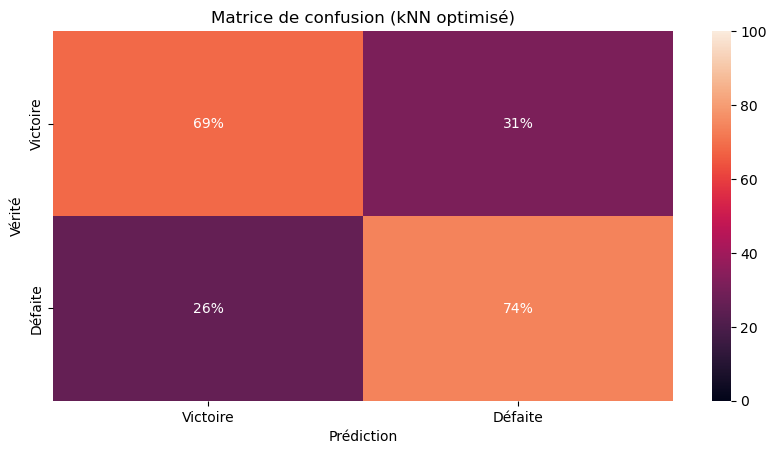

In [48]:
plt.figure()

sns.heatmap(
    (confusion_matrix(y_test, optimal_knn_model.predict(X_test_scaled), normalize='true'))*100,
    vmin=0,
    vmax=100,
    annot=True,
    xticklabels=['Victoire', 'Défaite'],
    yticklabels=['Victoire', 'Défaite']
)

for i, text in enumerate(plt.gca().texts):
    text.set_text(f"{text.get_text()}%")

plt.title('Matrice de confusion (kNN optimisé)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')

Pour l'optimisation des hyperparamètres du kNN, j'ai testé énormément de valeurs pour k (n_neighbors) que j'ai fait itérativement en regardant les résultats de chaque test. Si la GridSearch me donnait le k max que j'avais testé, je rajoutais des valeurs plus grandes pour voir si cela améliorait les performances. Inversement, si la GridSearch me donnait le k min que j'avais testé, je rajoutais des valeurs plus petites pour voir si cela améliorait les performances. Enfin, si la GridSearch me donnait un k entre 2 valeurs que j'avais testé, je raprochais les valeurs aux alentours de ce k pour voir si cela améliorait les performances.

Je n'ai pas remis le code avec toutes les valeurs car il est très long a éxécuter et n'apporte pas d'informations supplémentaires.

<h2 id='random-forest'>Random Forest</h3>

In [49]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train) # pas besoin du scaled pour le random forest

models_accuracy['Random Forest'] = rf_model.score(X_test, y_test)
print(f"Accuracy du modèle: {models_accuracy['Random Forest']:.2%}")
print(f'Rapport de classification : \n{classification_report(y_test, rf_model.predict(X_test))}')

Accuracy du modèle: 70.49%
Rapport de classification : 
              precision    recall  f1-score   support

       False       0.71      0.69      0.70      3087
        True       0.70      0.72      0.71      3141

    accuracy                           0.70      6228
   macro avg       0.70      0.70      0.70      6228
weighted avg       0.70      0.70      0.70      6228



Text(95.72222222222221, 0.5, 'Vérité')

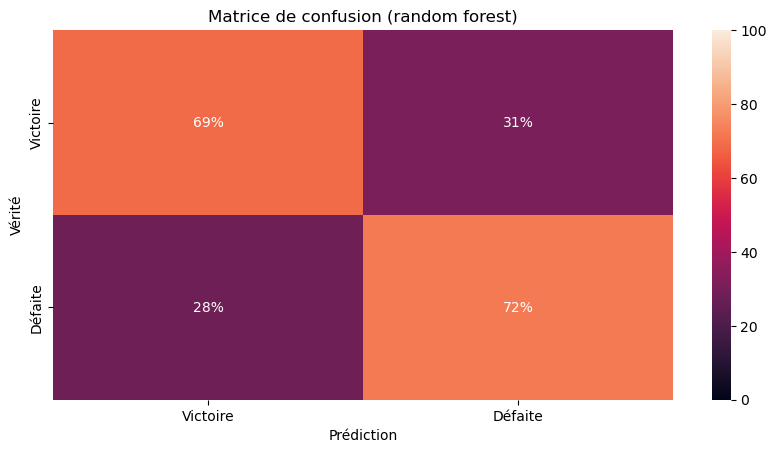

In [50]:
plt.figure()

sns.heatmap(
    (confusion_matrix(y_test, rf_model.predict(X_test), normalize='true'))*100,
    vmin=0,
    vmax=100,
    annot=True,
    xticklabels=['Victoire', 'Défaite'],
    yticklabels=['Victoire', 'Défaite']
)

for i, text in enumerate(plt.gca().texts):
    text.set_text(f"{text.get_text()}%")

plt.title('Matrice de confusion (random forest)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')

In [51]:
param_grid = {
    'n_estimators': [100, 200, 300], # nombre d'arbres
    'max_depth': [None, 10, 20, 30], # profondeur maximale de chaque arbre
    'min_samples_split': [2, 5, 10], # nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [1, 2, 4], # nombre minimum d'échantillons requis à chaque feuille
    'max_features': ['sqrt', 'log2'] # nombre de features à considérer pour la meilleure division
}

grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=kfold,
    scoring='accuracy',
    verbose=0,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
optimal_rf_model = grid_search.best_estimator_

# Display results
print(f'Meilleurs hyperparamètres: {grid_search.best_params_}')
models_accuracy['Random Forest optimise'] = optimal_rf_model.score(X_test, y_test)
print(f"Accuracy du modèle optimisé: {models_accuracy['Random Forest optimise']:.2%}")
print(f'Rapport de classification:\n{classification_report(y_test, optimal_rf_model.predict(X_test))}')

Meilleurs hyperparamètres: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300}
Accuracy du modèle optimisé: 72.01%
Rapport de classification:
              precision    recall  f1-score   support

       False       0.72      0.70      0.71      3087
        True       0.72      0.74      0.73      3141

    accuracy                           0.72      6228
   macro avg       0.72      0.72      0.72      6228
weighted avg       0.72      0.72      0.72      6228



Text(95.72222222222221, 0.5, 'Vérité')

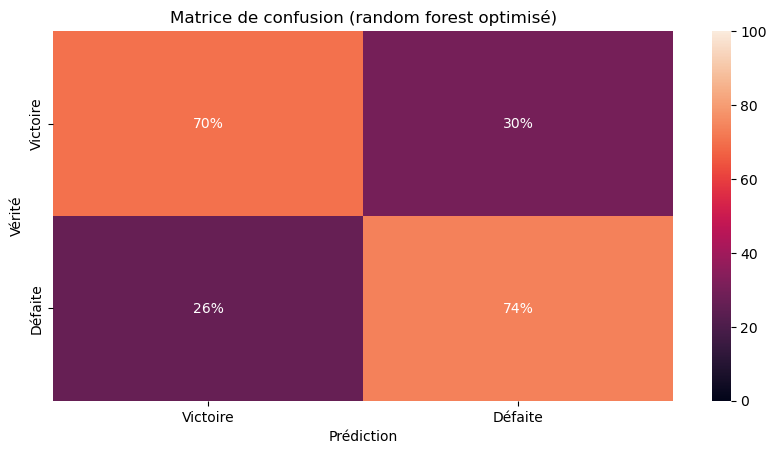

In [52]:
plt.figure()

sns.heatmap(
    (confusion_matrix(y_test, optimal_rf_model.predict(X_test), normalize='true'))*100,
    vmin=0,
    vmax=100,
    annot=True,
    xticklabels=['Victoire', 'Défaite'],
    yticklabels=['Victoire', 'Défaite']
)

for i, text in enumerate(plt.gca().texts):
    text.set_text(f"{text.get_text()}%")

plt.title('Matrice de confusion (random forest optimisé)')
plt.xlabel('Prédiction')
plt.ylabel('Vérité')

<h2 id='jungler'>Comment me comporter en tant que Jungle dans cette partie ?</h2>

Le jungler est de loin le rôle le plus important dans une partie de League of Legends. Il est chargé de contrôler la jungle, d'assurer les objectifs neutres (dragons, baron, hérald) et de ganker les lanes pour aider ses coéquipiers. Un bon jungle, surtout en soloQ, est l'élément clé pour gagner une partie.

On va donc essayer d'utiliser les modèles optimisés pour aider notre jungler à prendre les meilleures décisions possibles afin de maximiser ses probabilités de victoire.

Pour le moment, nous avons tiré les conclusions suivantes :
1. L'or et l'expérience sont les 2 aspects du jeu qui ont le plus d'impact sur la victoire.

2. Bâtiments : 
    
    a. Les tourelles bot ont un impact plus important sur la victoire que les autres tourelles.
    
    b. Les tourelles top ont un impact encore plus faible que les tourelles mid.

3. Objectifs neutres :
    
    a. Les dragons de terre, de feu et d'eau ont un impact similaire sur la victoire.

    b. Le dragon d'air a un impact plus faible que les autres dragons.
    
    c. L'Elder Dragon et le Baron Nashor ont un impact important sur la victoire. Cependant, le Baron Nashor a un impact légèrement plus important que l'Elder Dragon.

L'idée de cette partie de l'analyse est de construire un outils qui regarde l'état de la partie toutes les 2 minutes (à chaque frame) et qui donne des directives au joueur pour l'aider à prendre les meilleures décisions possibles (ex : aller jouer le dragon plutôt que l'hérald, aller ganker bot plutôt que top, etc.). Le jungler devant jouer autour de ses coéquipiers, il est le seul rôle pouvant avoir un impact général sur la partie (sauf en cas de stomp ou de troll).

Avant de commencer, il faut sélectionner le modèle le plus performant parmis les 6 (3 modèles, 2 versions par modèle) modèles. Pour cela, on va prendre celui avec la meilleur ccuracy.

In [62]:
pd.Series(models_accuracy).sort_values(ascending=False)

Régression logistique                         0.72
Random Forest optimise                        0.72
Régression logistique (goldDiff et expDiff)   0.71
kNN optimisé                                  0.71
Random Forest                                 0.70
kNN                                           0.68
dtype: float64

On choisit le modèle de régression logistique qui a la meilleur précision (côté à côté avec le random forest otpimisé mais qui est largement plus rapide).

On va créer un modèle spécialiser pour chaque frame étant donné que les parties ne se ressemblent pas du tout en fonction du moment. De plus, cela nous permettra de ne pas avoir plusieurs parties par jeu de données.

<Axes: >

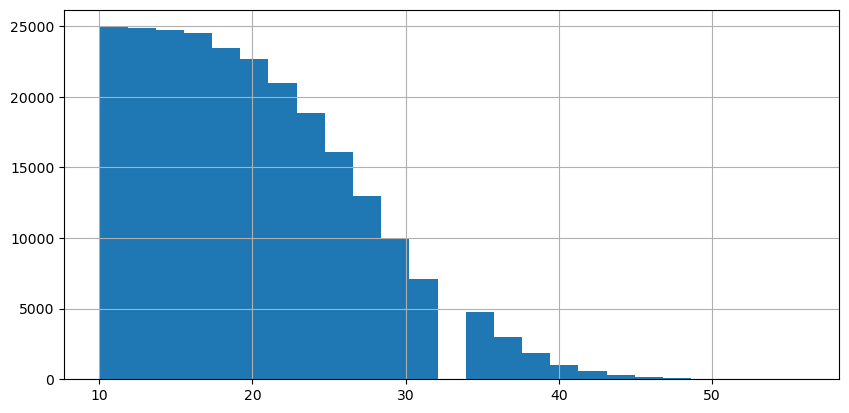

In [70]:
df_ml.frame.hist(bins=25)

On fait 1 modèle par frame (de 2 à 40) car on a pas suffisament de partie qui vont au delà de 40 dans le jeu de données et que, de toute façon , les parties ne vont généralement pas aussi loin.

In [110]:
models_per_frame = {}
coef_df = pd.DataFrame(index=X.columns)

for wanted_frame in range(10, 41, 2):
    # filtrage
    df_ml_for_logistic = df_ml[df_ml.frame==wanted_frame]

    # features scaled et target
    X = df_ml_for_logistic.drop(['gameId', 'hasWon', 'frame'], axis=1)
    y = df_ml_for_logistic.hasWon

    X_scaled = scaler.fit_transform(X)

    model = LogisticRegression(max_iter=1000)
    model.fit(X_scaled, y)

    models_per_frame[wanted_frame] = model
    coef_df[wanted_frame] = pd.Series(model.coef_[0], index=X.columns)
    print(f'Frame {wanted_frame} : {model.score(X_scaled, y):.2%}')

Frame 10 : 72.54%
Frame 12 : 74.84%
Frame 14 : 77.34%
Frame 16 : 79.01%
Frame 18 : 80.20%
Frame 20 : 81.15%
Frame 22 : 82.38%
Frame 24 : 83.33%
Frame 26 : 83.49%
Frame 28 : 83.54%
Frame 30 : 83.91%
Frame 32 : 83.31%
Frame 34 : 81.93%
Frame 36 : 79.93%
Frame 38 : 80.03%
Frame 40 : 81.34%


Le dictionnaire `models_per_frame` contient un modèle de régression logistique pour chaque frame de 10 à 40. On veut créer une fonction `jungler_helper()` pour donner aux junglers des instructions sur ce qu'ils doivent faire en fonction de la situation de jeu actuelle. Pour ce faire, la fonction prend en entrée la frame de jeu actuelle et chacune des variables utilisées pour entraîner les modèles de régression logistique (`X.columns`). La fonction sélectionne ensuite le modèle correct dans `models_per_frame` en fonction de la trame saisie en tant qu'argument de la fonction (par exemple : si `jungler_helper(10, *)` nous choisissons le modèle `models_per_frame[10]`). La fonction calcule ensuite la probabilité de victoire de l'équipe dans l'état actuel des choses, et fournit des recommandations basées sur cette probabilité et la distance de chaque variable par rapport à sa moyenne (pour détecter des retards ou des avancées dans certains aspects du jeu). La fonction prend également en compte les coefficients du modèle pour pondérer l'importance des écarts à la moyenne en fonction de leur impact sur le jeu à ce moment-là.

In [ ]:
def jungler_helper(frame, goldDiff, expDiff, champLevelDiff, isFirstTower, isFirstBlood, kills, deaths, assists, wardsPlaced, wardsDestroyed, wardsLost, earthDrakeDiff, fireDrakeDiff, waterDrakeDiff, airDrakeDiff, elderDrakeDiff, riftHeraldDiff, baronNashorDiff, topInhibitorDiff, midInhibitorDiff, botInhibitorDiff, topBaseTurretDiff, midBaseTurretDiff, botBaseTurretDiff, topInnerTurretDiff, midInnerTurretDiff, botInnerTurretDiff, topOuterTurretDiff, midOuterTurretDiff, botOuterTurretDiff):
    """
    Entrée : frame actuelle et toutes features du modèle de régression logistique (aspects du jeu)
    Sortie : conseils pour le jungler sur ce qu'il doit faire (ce sur quoi il est en avance, en retard et que faire en conséquence)
    """
    proba_initiale = logistic_model.predict_proba

<h1 id='conclusion'>Conclusion</h1>

Bien sûr, cette analyse n'est pas complète et comporte des failles. On aimerait bien avoir des données sur le nombre de points de vie restant à chaque tourelle ou le nombre de wards placées par chaque équipe par exemple. Pour être encore plus précis, il nous faudrait des données sur les champions que les joueurs ont joué, les runes et les objets qu'ils ont acheté. On pourrait également aller encore plus loin en disposant de données sur l'historique des parties des joueurs (first time, winrate sur ce champion, style de jeu, nombre de banissement pour voir la toxicité, etc.).

La psychologie des joueurs est également un aspect important à prendre en compte. Un joueur qui est en tilt (frustré) ou qui a un comportement toxique peut avoir un impact négatif sur la partie. Tout cela constitue des analyses supplémentaires qui serait intéressantes à réaliser mais dont nous ne disposons pas des données.